In [1]:
# Wrap the old code into kooplearn
import torch
import schnetpack
from kooplearn.models import DMD
from kooplearn.data import traj_to_contexts
import numpy as np
import matplotlib.pyplot as plt

class Namespace:
    def __init__(self, d):
        for k, v in d.items():
            if isinstance(v, dict):
                setattr(self, k, Namespace(v))
            else:
                setattr(self, k, v)
configs = Namespace({
    'data': {
        'cutoff': 5
    },
    'network': {
        'n_rbf': 20,
        'n_atom_basis': 64,
        'n_final_features': 16,
        'n_interactions': 3
    }
})

class SchNet(schnetpack.model.AtomisticModel):
    def __init__(self, configs: Namespace):
        super().__init__(
            input_dtype_str="float32",
            postprocessors=None,
            do_postprocessing=False,
        )
        self.cutoff = configs.data.cutoff
        self.pwise_dist = schnetpack.atomistic.PairwiseDistances()
        self.radial_basis = schnetpack.nn.GaussianRBF(n_rbf=configs.network.n_rbf, cutoff=self.cutoff)
        self.net = schnetpack.representation.SchNet(
            n_atom_basis=configs.network.n_atom_basis, 
            n_interactions=configs.network.n_interactions,
            radial_basis=self.radial_basis,
            cutoff_fn=schnetpack.nn.CosineCutoff(self.cutoff)
        )
        self.final_lin = torch.nn.Linear(configs.network.n_atom_basis, configs.network.n_final_features)
        self.batch_norm = torch.nn.BatchNorm1d(configs.network.n_final_features, affine=False)
    def forward(self, inputs: dict[str, torch.Tensor]) -> dict[str, torch.Tensor]:
        inputs = self.pwise_dist(inputs)
        inputs = self.net(inputs)
        inputs['scalar_representation'] = self.final_lin(inputs['scalar_representation'])
        return inputs['scalar_representation']

### Data loading

In [2]:
import os
from pathlib import Path
data_path = Path('data/')
db_path = data_path / 'CLN025-0-protein-ALL.db'
cache_path = data_path / 'cache'
nb_list_transform = schnetpack.transform.CachedNeighborList(cache_path, schnetpack.transform.MatScipyNeighborList(cutoff=configs.data.cutoff), keep_cache=True)
in_transforms = [schnetpack.transform.CastTo32(), nb_list_transform]
dataset = schnetpack.data.ASEAtomsData(str(db_path), transforms=in_transforms)
dataloader = schnetpack.data.AtomsLoader(dataset, num_workers=2, persistent_workers=True, batch_size = 1, shuffle=False)

In [3]:
state_dict = torch.load('schnet_model_ckpt.pt')
model = SchNet(configs)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
from tqdm import tqdm
features = []
model.eval()
chunk_idx = 0
chunk_size = 20000
if False:
    for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        with torch.no_grad():
            feats = model(batch)
        features.append(feats)
        if (batch_idx + 1) % chunk_size == 0:
            features = torch.stack(features, dim=0)
            torch.save(features, f'data/schnet_feats/chunk_{chunk_idx}.pt')
            features = []
            chunk_idx += 1
    features = torch.stack(features, dim=0)
    torch.save(features, f'data/schnet_feats/chunk_{chunk_idx}.pt')


In [5]:
#Load the features back to memory
num_chunks = len(os.listdir("data/schnet_feats"))
features = []
for i in range(num_chunks):
    features.append(torch.load(f'data/schnet_feats/chunk_{i}.pt'))
features = torch.cat(features, dim=0)

In [6]:
mean_embedding = torch.mean(features, dim=1)
mean_embedding = mean_embedding.numpy()

In [7]:
contexts = traj_to_contexts(mean_embedding)

In [8]:
dmd_model = DMD(reduced_rank = False, rank = 16)
dmd_model.fit(contexts)

Fitted DMD model. Lookback length set to 1


In [9]:
eig, lf, rf = dmd_model.eig(eval_left_on = contexts[:, dmd_model.lookback_len:, ...], eval_right_on = contexts[:, dmd_model.lookback_len:, ...])

In [10]:
lf.shape

(524742, 16)

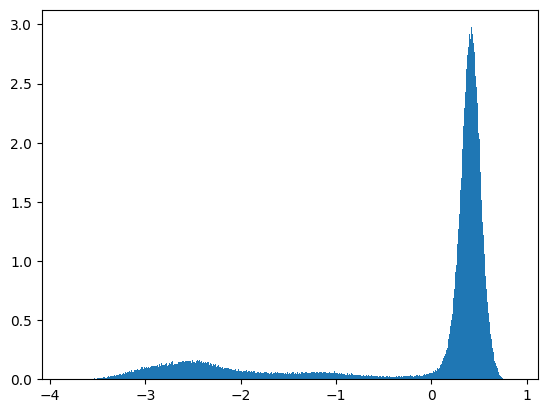

In [13]:
bins = 1000
plt.hist(lf[:, -2], bins = bins, density=True);

In [18]:
def implied_timescales(eigvals, lagtime):
    return -lagtime/(np.log(np.abs(eigvals)))

dt = 0.2 #ns
#

In [15]:
dmd_model.eig().sum()

(14.282188+0j)

In [14]:
print(implied_timescales(dmd_model.eig(), dt))

[  0.57381463   0.8120724    1.0774456    1.1300983    1.3021536
   1.3344892    1.5089793    1.6097833    2.3308525    2.6301708
   3.6168768    3.6283338    3.827861     8.052493    17.593748
 135.6215    ]


# Nystrom Models

In [1]:
import os
os.environ["CUDA_PATH"] = "/home/novelli/anaconda3/envs/nyskoop"
import numpy as np
import torch
pwdist = np.load("/home/novelli/dp_examples/chignolin/data/CLN025_heavy_pwisedist.npy")
pwdist = torch.from_numpy(pwdist)
# Data Normalization
feature_norm = torch.linalg.norm(pwdist, dim=0, keepdim=True)
feature_mean = torch.mean(pwdist, dim=0, keepdim=True)
pwdist -= feature_mean
pwdist /= feature_norm

In [2]:
import pickle
nystrom_models = {}
for model in ['pcr','rrr']:
    with open(f'ckpt/nystrom_{model}.pkl', 'rb') as f:
        nystrom_models[model] = pickle.load(f)

In [3]:
for model in ['pcr','rrr']:
    est = nystrom_models[model]['estimator']
    v, lf_fn, r_fn = est.eigenfunctions()
    v = v.resolve_conj().numpy()
    lf = lf_fn(pwdist).numpy()
    rf = r_fn(pwdist).numpy()
    sort_perm = np.argsort(v)[::-1]
    np.savez(f'data/nystrom_evd/{model}.npz', eigenvalues=v[sort_perm], left_fns=lf[:, sort_perm], right_fns=rf[:, sort_perm])

In [8]:
v, lf_fn, r_fn = est.eigenfunctions()

In [3]:
np.argsort(np.arange(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
lf = lf_fn(pwdist)

In [13]:
lf = lf.numpy()

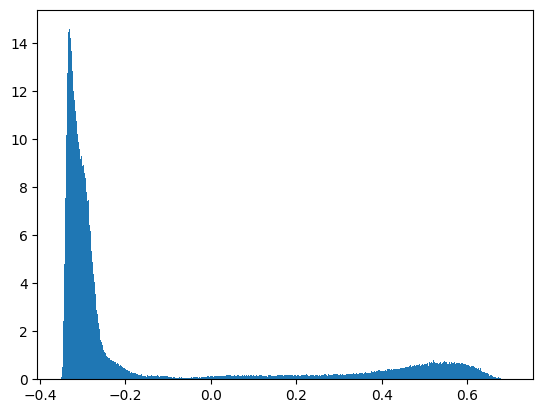

In [16]:
import matplotlib.pyplot as plt
plt.hist(lf[:, 1].real, bins = 1000, density=True);

In [19]:
print(implied_timescales(v.resolve_conj().numpy(), dt))

[95.838295    7.5872793   1.1889821   1.1159911   0.8237654   0.7524317
  0.6694608   0.58439004  0.44238803  0.39537108  0.3649637   0.3305681
  0.30275244  0.24980013  0.22199486  0.21354909]
